# Music Source Separator Basic Implementations

Before I start working on MSS implementations using multi-layered neural networks, I want to start off with some of the most basic forms of MSS. I decided that a good start would be Harmonic-Percussive Source decomposition, as it a relatively simple to perform and understand. 

## Harmonic Percussive Source Decomposition (HPS)

The inituition of HPS is very straightforward to follow. Lets look at some spectrograms of a piece of music. The spectrograms show the full mix on the left, then drums, bass, etc. 

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import musdb
import hps

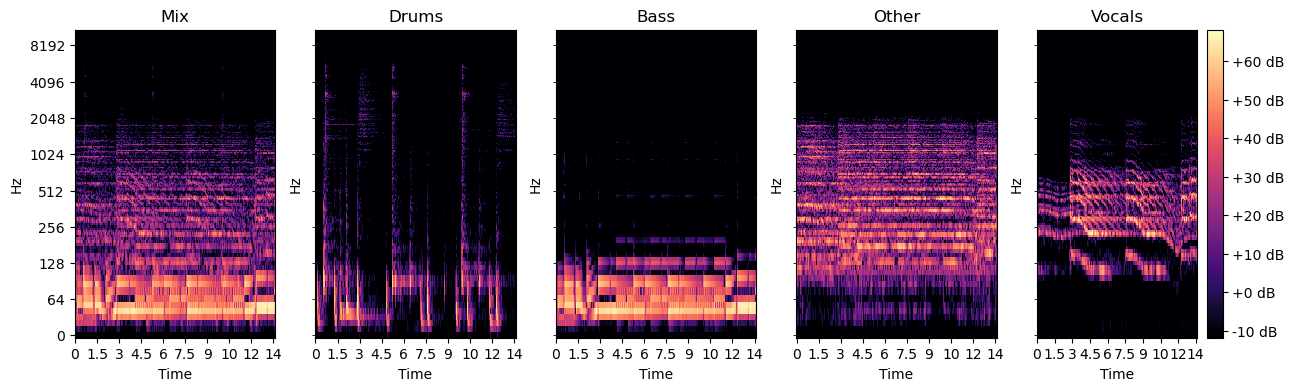

In [2]:
mus = musdb.DB(download=True)
night_owl = mus[0]
specs, X_s = hps.plot_spectrograms(night_owl)

Something you might notice a clear distinction in some of the spectrograms shapes. Some appear more like horizontal lines shifting slightly, while some appear more like vertical lines. The distinctions comes from the nature of these sources; the vertical shapes come from percussive elements of a song, while the horizontal lines come from harmonic elements.

With this there is a clear path forward, if we can somehow get a function that detects when a song is vertical or horizontal we should be golden! 

## Median Filtering

Enter: median filtering, while this may have not been your first thought on how to capture vertical and horizontal lines, the idea behind it is quite easy to understand with a bit explanation. First what is median filtering. Say we have a group of pixels to be filtered, if we take their values, sort them, and then return the median value that's median filtering!

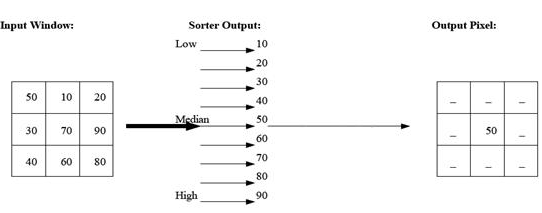

The really important feature of median filtering that makes it work for detecting horizontal and vertical lines is edge preservation. The intuition behind this can be somewhat tricky, but say our input looks like this with a very clearly defined edge. (insert image of matrice in this video: https://www.youtube.com/watch?v=l1jBzR7pE8s) When you go over it with a median filter the outputs will not lose the edge, since it simply will return the edge color of one side when the filter contains more of that value and then then the edge color of the other side once the filter shifts enough to make that value the median. 

Apply this to our context, this edge preservation is what we need to get our lines. Think of applying an median filter in the form of taking our image in 1 pixel wide vertical or horizontal cuts of our spectrogram. Then depending on how long the filter is, it should be able to tell when an input is exhibiting behavior of a vertical or horizontal line. 

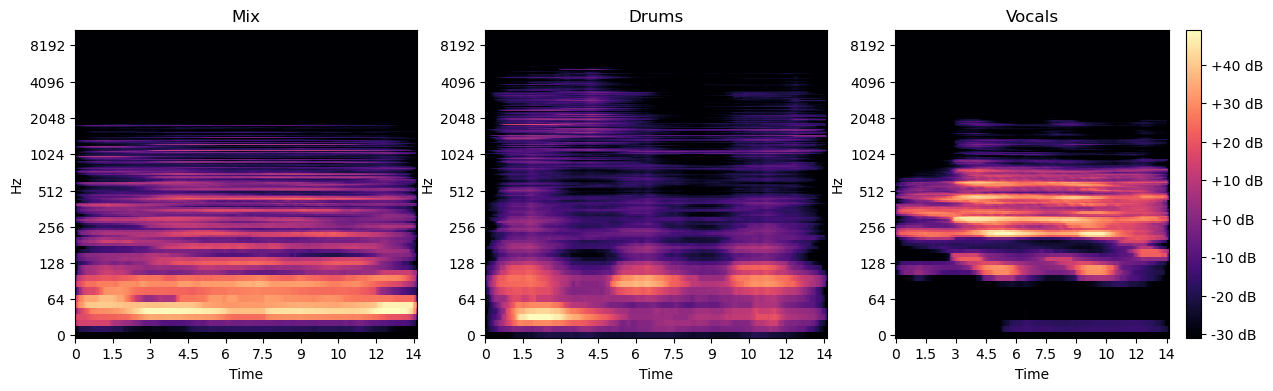

In [3]:
mix, drums, bass, other, vocal = specs
h_filtered_signals = hps.med_filter_specs((mix, drums, vocal), 111, hori=True)

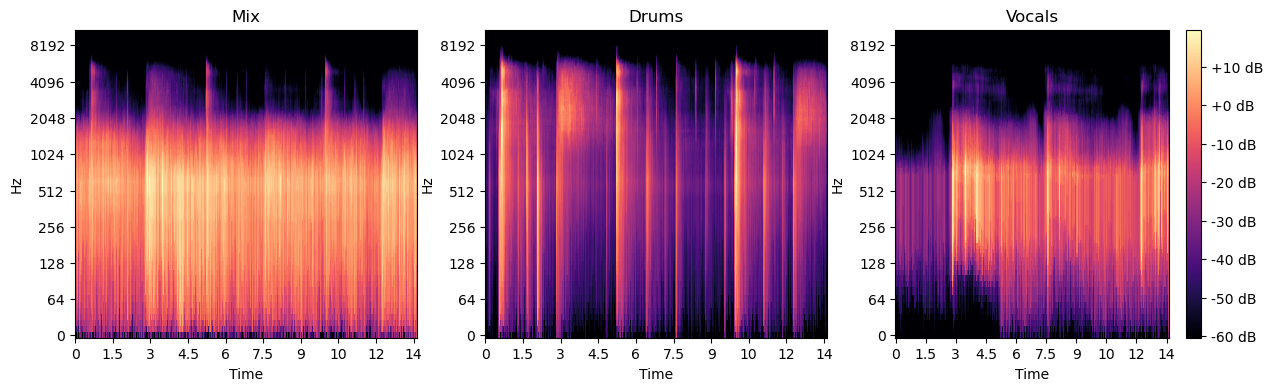

In [4]:
v_filtered_signals = hps.med_filter_specs((mix, drums, vocal), 111, hori=False)

## Creating the Masks

Unfortunately we cannot just play the filtered audio signal data values to create our, estimated sources. To get our desired outputs, we will need to apply some sort of mask to the mixed audio to isolate what our filter found to be a vertical vs horizontal line in the spectrogram. This is quite easy though, since our filtered audio data is the same exact size as our audio stft inputs, we simply multiply the filtered audio data with the stft data element-wise, perform an inverse stft and we have our audio!

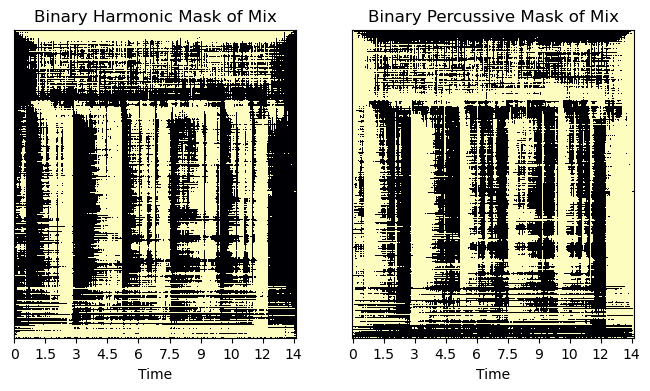

In [5]:
M_bin_h, M_bin_p = hps.plot_binary_masks(h_filtered_signals, v_filtered_signals)

In [7]:
X = X_s[0] 

X_h = X * M_bin_h
X_p = X * M_bin_p

x_h = librosa.istft(X_h, n_fft=2048, hop_length=2048 //4, window='hann', center=True)
x_p = librosa.istft(X_p, n_fft=2048, hop_length=2048 //4, window='hann', center=True)

print('True Mix signal')
ipd.display(ipd.Audio(data=night_owl.stems[0].T, rate=night_owl.rate))
print('Harmonic component signal')
ipd.display(ipd.Audio(data=x_h, rate=night_owl.rate))
print('Percussive component signal')
ipd.display(ipd.Audio(data=x_p, rate=night_owl.rate))


True Mix signal


Harmonic component signal


Percussive component signal


## Results

The results of the filtering are surprisingly great for the simplicity of the design. To be fair this is only splitting the audio into two distinct sources rather the 5 of most state-of-the-art MSS's, but regardless I am pleasantly surprised how fair such a simple algorithm can get.